In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset path
original_dataset_dir = r"C:\Users\uniq\Downloads\archive"
# New base directory for train/val/test split
base_dir = r"C:\Users\uniq\Downloads\garbage_split"
os.makedirs(base_dir, exist_ok=True)

# Create train/val/test folders
for split in ["train", "val", "test"]:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)

# Classes (based on your dataset structure)
classes = [
    "battery",
    "biological",
    "brown-glass",
    "cardboard",
    "clothes",
    "green-glass",
    "metal",
    "paper",
    "plastic",
    "shoes",
    "trash",
    "white-glass"
]

# Split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

for class_name in classes:
    src_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.exists(src_dir):
        print(f"⚠️ Skipping missing class folder: {class_name}")
        continue

    images = os.listdir(src_dir)

    # Train/val/test split
    train_files, temp_files = train_test_split(images, test_size=(1-train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(test_ratio+val_ratio), random_state=42)

    for split, file_list in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for fname in file_list:
            src = os.path.join(src_dir, fname)
            dst = os.path.join(split_class_dir, fname)
            shutil.copy(src, dst)

print("✅ Dataset split completed at:", base_dir)


✅ Dataset split completed at: C:\Users\uniq\Downloads\garbage_split


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths after split
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Image size and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 10853 images belonging to 12 classes.
Found 2329 images belonging to 12 classes.
Found 2333 images belonging to 12 classes.


Found 14129 images belonging to 12 classes.
Found 4298 images belonging to 12 classes.
Found 4346 images belonging to 12 classes.
✅ Class Weights: {np.int32(0): np.float64(1.3627507716049383), np.int32(1): np.float64(1.3111544172234595), np.int32(2): np.float64(2.1214714714714713), np.int32(3): np.float64(1.4446830265848671), np.int32(4): np.float64(0.2432176547545273), np.int32(5): np.float64(2.0729166666666665), np.int32(6): np.float64(1.6868433619866285), np.int32(7): np.float64(1.2239258489258489), np.int32(8): np.float64(1.4810272536687632), np.int32(9): np.float64(0.6570405505952381), np.int32(10): np.float64(1.8630010548523206), np.int32(11): np.float64(1.6606723084156088)}


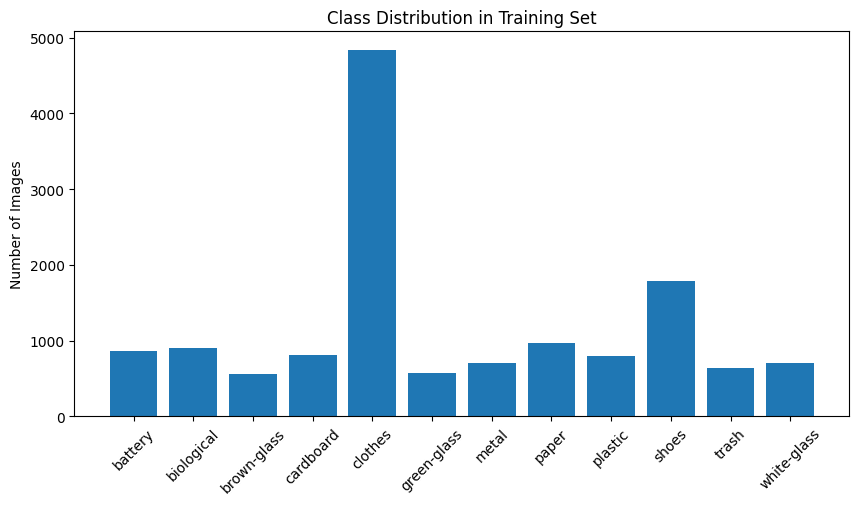

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Dataset paths (after splitting)
base_dir = r"C:\Users\uniq\Downloads\garbage_split"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# ===============================
# 1. Data Augmentation (Training)
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalization
    rotation_range=20,           # Random rotation
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.15,            # Shear transform
    zoom_range=0.2,              # Zoom
    horizontal_flip=True,        # Flip horizontally
    fill_mode="nearest"          # Fill empty pixels
)

# ===============================
# 2. Validation & Test (Only Normalize)
# ===============================
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ===============================
# 3. Create Generators
# ===============================
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="rgb"   # <-- ensure 3 channels
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb"
)


# ===============================
# 4. Handle Class Imbalance
# ===============================
# Get class indices and counts
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Convert generator classes into numpy array
y_train = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

print("✅ Class Weights:", class_weights)

# ===============================
# 5. Plot Class Distribution
# ===============================
counts = np.bincount(y_train)
plt.figure(figsize=(10,5))
plt.bar(class_labels, counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()


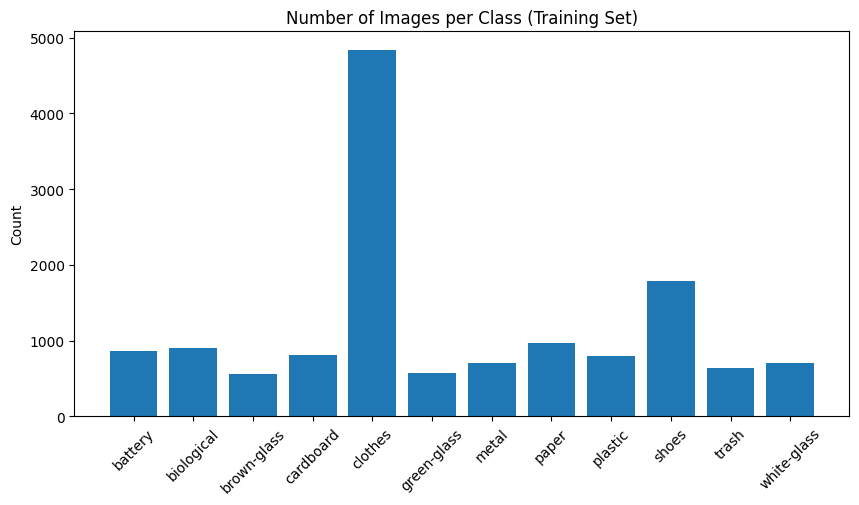

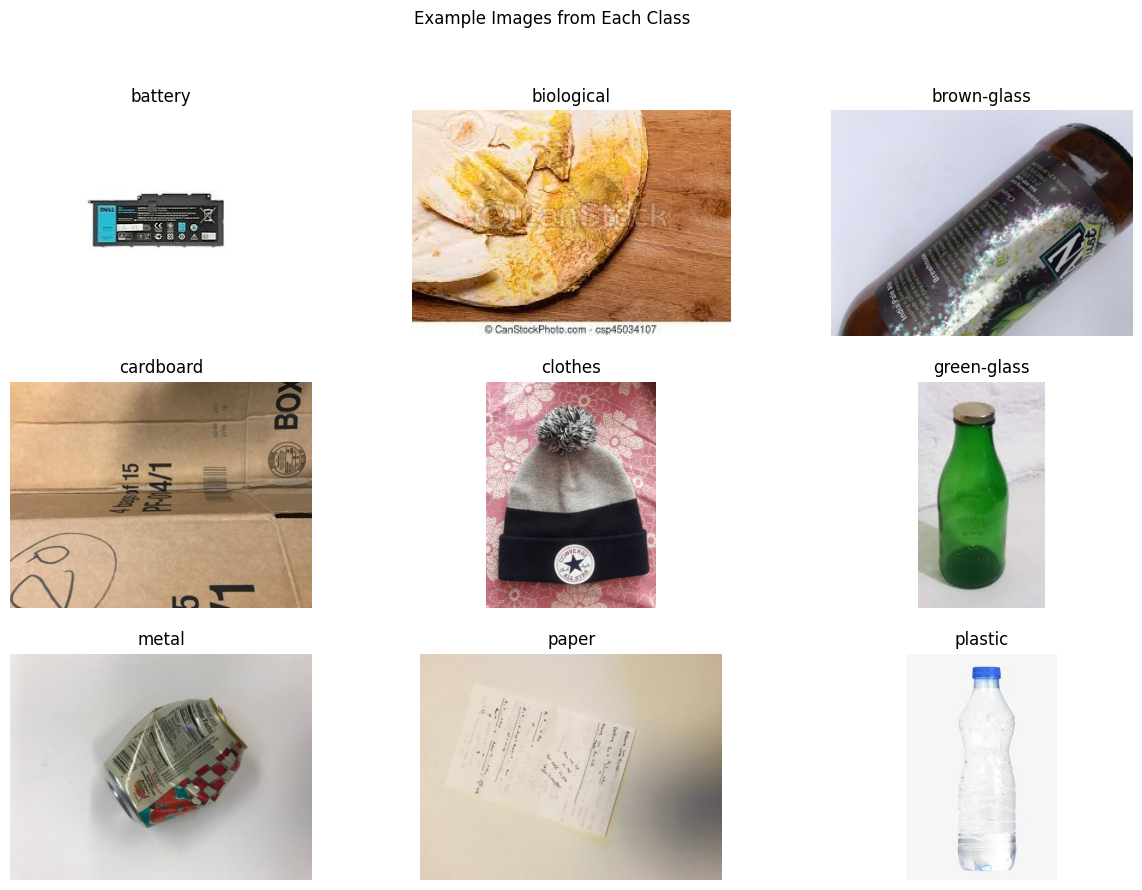

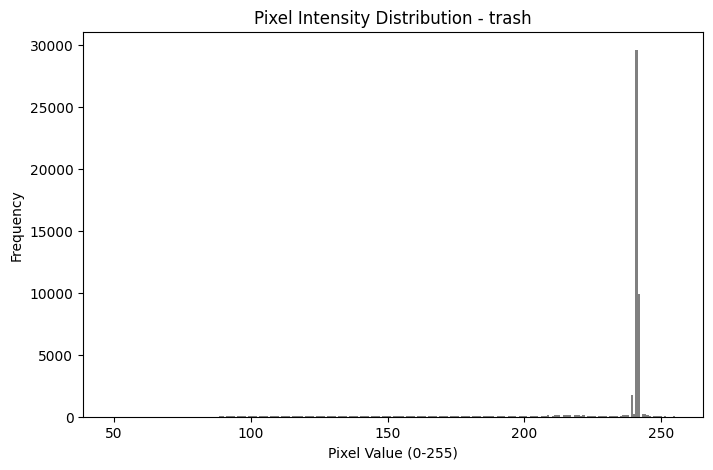

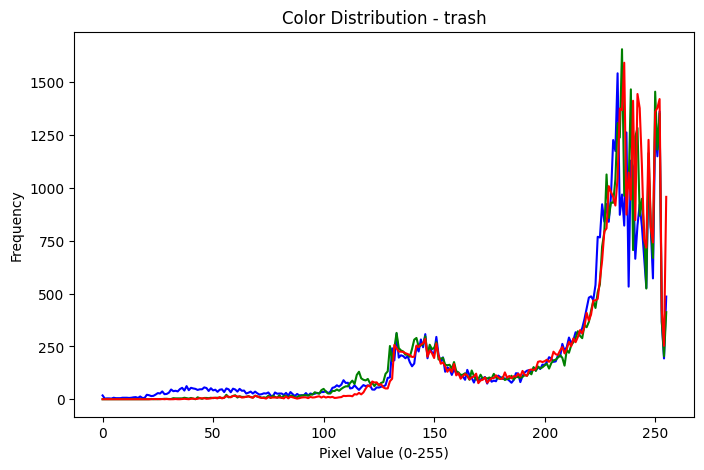

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Path to dataset (after splitting)
train_dir = r"C:\Users\uniq\Downloads\garbage_split\train"

# Get class names
classes = os.listdir(train_dir)
classes.sort()

# ===============================
# 1. Number of Images per Class
# ===============================
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

plt.figure(figsize=(10,5))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Number of Images per Class (Training Set)")
plt.ylabel("Count")
plt.show()

# ===============================
# 2. Show Example Images
# ===============================
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes[:9]):  # show up to 9 classes
    class_path = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Example Images from Each Class")
plt.show()

# ===============================
# 3. Pixel Intensity Distribution (Grayscale)
# ===============================
sample_class = random.choice(classes)
sample_path = os.path.join(train_dir, sample_class)
sample_img = cv2.imread(os.path.join(sample_path, random.choice(os.listdir(sample_path))), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,5))
plt.hist(sample_img.ravel(), bins=256, color="gray")
plt.title(f"Pixel Intensity Distribution - {sample_class}")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

# ===============================
# 4. Color Distribution (RGB Channels)
# ===============================
sample_img_color = cv2.imread(os.path.join(sample_path, random.choice(os.listdir(sample_path))))
colors = ('b', 'g', 'r')

plt.figure(figsize=(8,5))
for i, col in enumerate(colors):
    hist = cv2.calcHist([sample_img_color], [i], None, [256], [0,256])
    plt.plot(hist, color=col)
plt.title(f"Color Distribution - {sample_class}")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ===============================
# 6. Model Development
# ===============================
NUM_CLASSES = 12   # directly set number of classes

# Choose base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze base layers
base_model.trainable = False

# Build model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [6]:
# 5) Evaluation: metrics and confusion matrix
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
best = keras.models.load_model('best_efficientnet.keras') if os.path.exists('best_efficientnet.keras') else model

# Evaluate
loss, acc = best.evaluate(test_ds)
print({'test_loss': float(loss), 'test_accuracy': float(acc)})

# Predictions
y_true = []
y_pred = []
for batch_imgs, batch_labels in test_ds:
    probs = best.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1).tolist())
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [1]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# ===============================
# 1. Load Model
# ===============================
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("garbage_classifier.h5")
    return model

model = load_model()

# Define class labels (must match your training dataset classes)
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'organic']

# ===============================
# 2. Streamlit UI
# ===============================
st.set_page_config(page_title="Garbage Classification App", page_icon="🗑️", layout="centered")

st.title("🗑️ Garbage Classification App")
st.write("Upload an image of garbage, and the model will predict its category with confidence score.")

uploaded_file = st.file_uploader("Choose a garbage image...", type=["jpg", "jpeg", "png"])

# ===============================
# 3. Prediction
# ===============================
if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    st.subheader("Prediction Results")
    st.write(f"**Category:** {class_labels[predicted_class]}")
    st.write(f"**Confidence:** {confidence*100:.2f}%")


Overwriting app.py


In [ ]:
!streamlit run app.py